<center> <font face="黑体" size=5>采用FbProphet算法预测公司供水总量模型</font> </center>

***谢杰***<br/>
***2020年7月***

本模型基于facebook开源的prophet算法开源库。特点是可以同时模拟时间序列的发展趋势、周期变化、节假日影响以及相关因素。建模流程遵循抽样、探索、修订、建模、评估、应用的实施方法论。

## 1. 调用相关的模块

In [1]:
#调入常用包
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
mpl.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import sys
import os

In [2]:
#查看当前目录
os.getcwd()

'C:\\Users\\XieJie\\mypyworks'

In [3]:
#调入查询台账模块
try:
    sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__),"StatLedger\module")))
except:
    sys.path.append(r'.\StatLedger\module')
import tjfxdata as tjfx

## 2. 获取供水数据和温度数据

In [4]:
#从数据库提取数据
list1 = [['00','00718','d'],#供水总量
         ['00','12190','d'],#最高温度
         ['00','12225','d'],#最低温度
        ]
shuju_df = tjfx.TjfxData().getdata('20150101','20201015',list1)
shuju_df.QUOTA_VALUE = pd.to_numeric(shuju_df.QUOTA_VALUE,errors='coerce')

In [5]:
shuju_df

,QUOTA_DATE,QUOTA_DEPT_CODE,QUOTA_CODE,QUOTA_VALUE,RECORD_TYPE,QUOTA_NAME,GROUP_NAME
0,2015-01-22,00,00718,4034859.0,d,水厂供水总量,广州自来水公司
1,2015-01-30,00,00718,3868633.0,d,水厂供水总量,广州自来水公司
2,2015-01-29,00,00718,3894778.0,d,水厂供水总量,广州自来水公司
3,2015-01-19,00,00718,4049507.0,d,水厂供水总量,广州自来水公司
4,2015-01-03,00,00718,4055444.0,d,水厂供水总量,广州自来水公司
...,...,...,...,...,...,...,...
6340,2020-10-11,00,12225,20.0,d,最低温度,广州自来水公司
6341,2020-10-12,00,12225,22.0,d,最低温度,广州自来水公司
6342,2020-10-13,00,12225,23.0,d,最低温度,广州自来水公司
6343,2020-10-15,00,12225,23.0,d,最低温度,广州自来水公司


In [6]:
#数据处理宽表格式
sup_water = pd.pivot_table(shuju_df,index = ['QUOTA_DATE'],columns = ['GROUP_NAME','QUOTA_NAME'],
                      values='QUOTA_VALUE')

In [7]:
#简化复合列名
sup_water = sup_water['广州自来水公司'].reset_index()
sup_water.columns =sup_water.columns.values 
# 或者使用下面代码
# sup_water.columns = sup_water.columns.get_level_values(1).values
# sup_water.reset_index()

In [9]:
sup_water.to_excel('./mypyworks/输出/2015-2020日供水总量.xlsx')

## 3. 数据选择

In [9]:
#设置模型数据日期范围
end_date = '2019-07-12'#设定模型数据结束日期
test_len = 31          #设定预留测试集长度
horizon = 31           #设定模型预测长度
period = 7             #设定训练集每折滑动期数
initial = 365 *2       #设定模型的训练集长度
cv = 10                 #设定交叉验证折数

In [10]:
#计算模型需要数据跨度
data_len = initial + period *(cv-1) + horizon + test_len
data_len

855

In [11]:
#根据模型数据时期跨度计算模型数据开始时间
start_date = (dt.datetime.strptime(end_date,'%Y-%m-%d') - dt.timedelta(days = data_len ) ).strftime('%Y-%m-%d')

In [12]:
#提取模型所需数据
sup_water = sup_water.set_index('QUOTA_DATE').sort_index()[start_date:end_date]

In [13]:
sup_water

,最低温度,最高温度,水厂供水总量
QUOTA_DATE,,,
2017-03-09,13.0,14.0,4009620.0
2017-03-10,13.0,16.0,4025949.0
2017-03-11,16.0,17.0,3929277.0
2017-03-12,17.0,21.0,3997271.0
2017-03-13,19.0,24.0,4150238.0
...,...,...,...
2019-07-08,28.0,33.0,4673062.0
2019-07-09,27.0,32.0,4631672.0
2019-07-10,25.0,29.0,4532901.0


## 4. 数据清洗

In [14]:
#找出缺失值
sup_water[sup_water.isnull().any(axis=1)]

,最低温度,最高温度,水厂供水总量
QUOTA_DATE,,,


In [15]:
#统计非数值个数
sup_water['最高温度'][~np.isfinite(sup_water['最高温度'])==1].count()
# print(sup_water['最高温度'].value_counts(dropna=False))

0

In [16]:
#判断数据框里面所有不是有限数据的数，可以排除null，np.nan,np.inf
sup_water[~(np.isfinite(sup_water).all(axis=1))]

,最低温度,最高温度,水厂供水总量
QUOTA_DATE,,,


**提示**：如果存缺失值、无穷大量、无穷小量则需要手工补录数据，并重新提取数据。

In [20]:
#判断离群值
#计算总体偏离值的标准差
quota = '水厂供水总量' #选择指标名称
window = 3             #选择移动平均长度
std_n = 3              #标准差个数
am = sup_water[quota].rolling(window=window,min_periods=0,center=True).mean()
diff = sup_water[quota].values - am
print(sup_water[np.abs(diff)> std_n * diff.std(ddof=0)])

            最低温度  最高温度     水厂供水总量
QUOTA_DATE                       
2017-03-31  15.0  24.0  3973608.0
2017-08-23  25.0  28.0  4410880.0
2018-01-01  10.0  19.0  4225304.0
2018-02-01   3.0  13.0  4248775.0
2018-02-16  14.0  27.0  3240058.0
2018-03-08  10.0  14.0  4118609.0
2018-09-16  24.0  32.0  4300136.0
2019-03-23  14.0  18.0  4168103.0


**提示：**出现离群值预警后，需要对数据进行核查，如果无法核实可以设置为缺失值，prophet模型可以自动处理缺失值。

Text(0.5, 1.0, '动态判断时间序列的离群值')

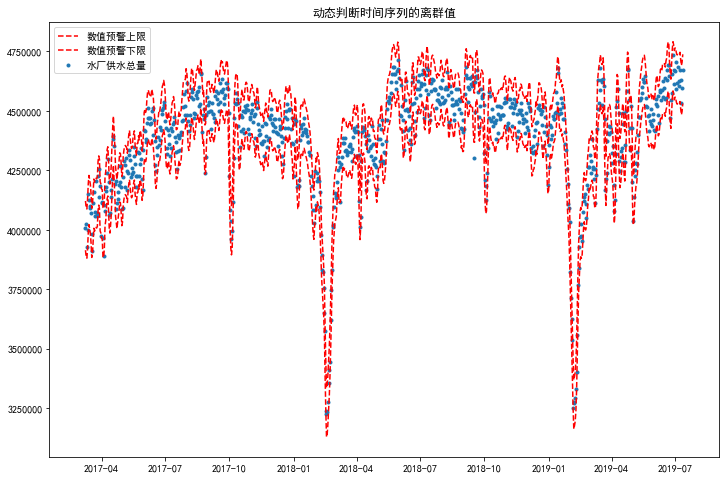

In [21]:
#可视化离群值
plt.figure(figsize=(12,8))
plt.scatter(x= sup_water.index.values,
         y =sup_water[quota], 
         marker='.',label=quota)
plt.plot(sup_water.index.values,am+std_n * diff.std(ddof=0),'r--',label='数值预警上限')
plt.plot(sup_water.index.values,am-std_n * diff.std(ddof=0),'r--',label='数值预警下限')
plt.legend(loc='best')
plt.title("动态判断时间序列的离群值")

**提示** ：出现离群值重新复核数据是否正常

## 5. 数据关系探索

In [22]:
#添加平均温度自变量
sup_water.eval("平均温度=(最高温度+最低温度)/2",inplace=True)

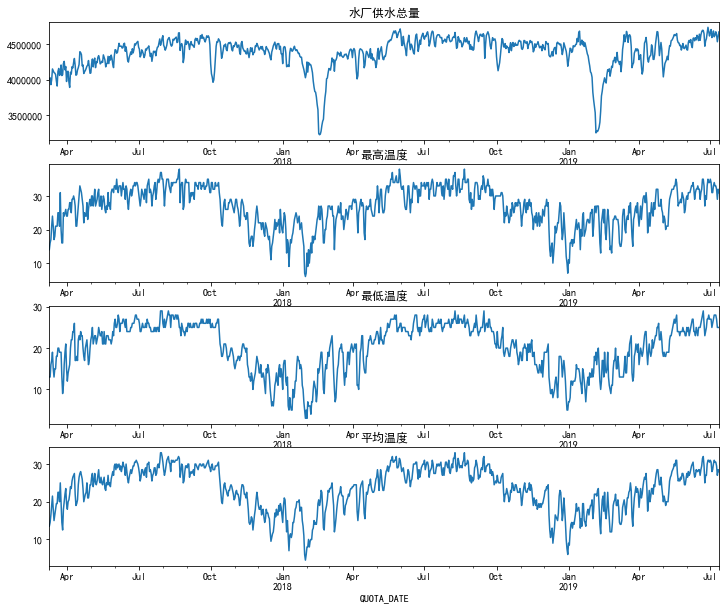

In [23]:
#画出各变量曲线图
plt.figure(figsize=(12,10))
plt.subplot(411)
sup_water['水厂供水总量'].plot(title='水厂供水总量')
plt.subplot(412)
sup_water['最高温度'].plot(title='最高温度') 
plt.subplot(413)
sup_water['最低温度'].plot(title='最低温度')
plt.subplot(414)
sup_water['平均温度'].plot(title='平均温度')

In [24]:
#多项式处理各自变量观察与目标变量的相关性
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3,include_bias=1)#最高三次方处理
X_poly = poly_features.fit_transform(sup_water[['最低温度','最高温度','平均温度']])

In [25]:
#将poly数组转成dataframe做相关矩阵
sup_water_poly= pd.DataFrame(data=X_poly,columns=poly_features.get_feature_names())
sup_water_poly['水厂供水总量'] = sup_water['水厂供水总量'].values
sup_water_poly.corrwith(sup_water_poly['水厂供水总量']).sort_values(ascending=False)

水厂供水总量      1.000000
x2^3        0.496935
x0 x1 x2    0.496434
x0 x1^2     0.496263
x1 x2^2     0.496167
x0 x2^2     0.494829
x0^2 x1     0.493808
x1^2 x2     0.493081
x0^2 x2     0.490357
x1^3        0.487144
x2^2        0.486106
x1 x2       0.485576
x0 x1       0.484436
x0^3        0.484008
x0 x2       0.480448
x1^2        0.479569
x0^2        0.471405
x2          0.464430
x1          0.461647
x0          0.444777
1                NaN
dtype: float64

**x0代表最低温度，x1代表最高温度，x2代表平均温度。因相关系数差异不大，为了简化模型选择x2平均温度作为模型的回归因素**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A34944B148>,
      dtype=object)

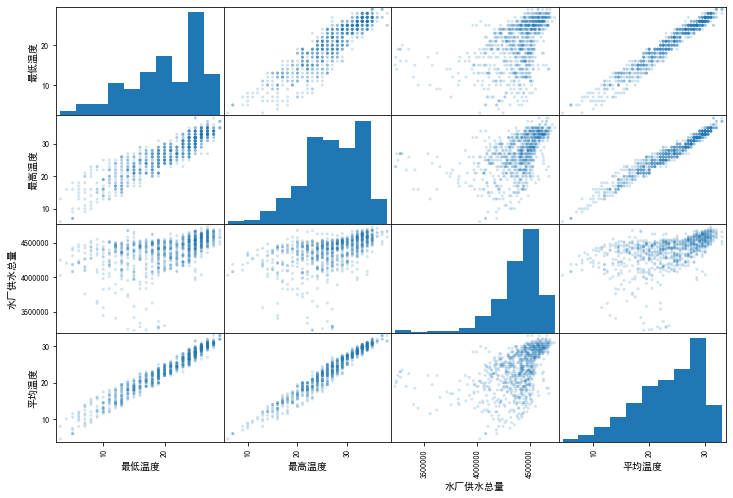

In [26]:
#做相关矩系数阵和相关性图
#sup_water.corr()
pd.plotting.scatter_matrix(sup_water,figsize=(12,8),alpha=0.2)

## 6. 训练模型

In [27]:
#调用prophet模型
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation 
# from sklearn.metrics import mean_squared_error

Importing plotly failed. Interactive plots will not work.


In [28]:
#修改变量名为prophet标准变量名
sup_water=sup_water.reset_index()[['QUOTA_DATE','水厂供水总量','平均温度']].rename(columns={'QUOTA_DATE':'ds','水厂供水总量':'y'})

In [29]:
#划分训练数据集和测试数据集
sup_water_train = sup_water[:-test_len] #训练数据集
sup_water_test = sup_water[-test_len:]  #测试数据集
print(sup_water_train)
print(sup_water_test)

            ds          y  平均温度
0   2017-03-09  4009620.0  13.5
1   2017-03-10  4025949.0  14.5
2   2017-03-11  3929277.0  16.5
3   2017-03-12  3997271.0  19.0
4   2017-03-13  4150238.0  21.5
..         ...        ...   ...
820 2019-06-07  4482464.0  29.5
821 2019-06-08  4449944.0  30.0
822 2019-06-09  4580536.0  30.5
823 2019-06-10  4586441.0  28.0
824 2019-06-11  4546347.0  26.5

[825 rows x 3 columns]
            ds          y  平均温度
825 2019-06-12  4588774.0  27.0
826 2019-06-13  4558989.0  28.5
827 2019-06-14  4623845.0  28.0
828 2019-06-15  4597152.0  28.0
829 2019-06-16  4549477.0  28.5
830 2019-06-17  4639759.0  28.5
831 2019-06-18  4553655.0  27.0
832 2019-06-19  4628503.0  28.5
833 2019-06-20  4673256.0  29.5
834 2019-06-21  4693815.0  31.5
835 2019-06-22  4691995.0  32.0
836 2019-06-23  4645082.0  29.5
837 2019-06-24  4470136.0  25.0
838 2019-06-25  4544049.0  27.0
839 2019-06-26  4576030.0  27.0
840 2019-06-27  4656036.0  30.0
841 2019-06-28  4736129.0  31.0
842 2019-06-29  

In [30]:
#对数化处理
#sup_water['y'] = np.log(sup_water['y'])

In [31]:
#标识对水量影响较大的时段
#标识国庆节
guoqing = pd.DataFrame({
  'holiday': 'guoqing',
  'ds': pd.date_range(start= '2015-10-1',periods=7,freq='AS-OCT'),
  'lower_window': 0,
  'upper_window': 6,
})
#标识农历春节
import sxtwl
lunar = sxtwl.Lunar()
spring_date=[]
for i in list(range(2014,2021)):
    solar_day = lunar.getDayByLunar(i,12,30)
    solar_date = dt.date(solar_day.y, solar_day.m, solar_day.d)
    spring_date.append(solar_date)
    
spring = pd.DataFrame({
  'holiday': 'spring',
  'ds':spring_date,
  'lower_window': -14,
  'upper_window': 14,
})
#标识新冠疫情期
#一级响应期
covid1 = pd.DataFrame({
  'holiday': 'covid1',
  'ds':pd.date_range(start= '2020-1-23',end='2020-2-23'),
  'lower_window': 0,
  'upper_window': 0,
})
#二级响应期
covid2 = pd.DataFrame({
  'holiday': 'covid2',
  'ds':pd.date_range(start= '2020-2-24',end='2020-5-8'),
  'lower_window': 0,
  'upper_window': 0,
})
#三级响应期
covid3 = pd.DataFrame({
  'holiday': 'covid3',
  'ds':pd.date_range(start= '2020-5-9',end='2020-8-13'),
  'lower_window': 0,
  'upper_window': 0,
})
holidays = pd.concat((guoqing, spring,covid1,covid2,covid3))

In [32]:
holidays

,holiday,ds,lower_window,upper_window
0,guoqing,2015-10-01 00:00:00,0,6
1,guoqing,2016-10-01 00:00:00,0,6
2,guoqing,2017-10-01 00:00:00,0,6
3,guoqing,2018-10-01 00:00:00,0,6
4,guoqing,2019-10-01 00:00:00,0,6
...,...,...,...,...
92,covid3,2020-08-09 00:00:00,0,0
93,covid3,2020-08-10 00:00:00,0,0
94,covid3,2020-08-11 00:00:00,0,0
95,covid3,2020-08-12 00:00:00,0,0


In [33]:
# 设置需要比较的超参数
growth =["linear","logistic"]

def seq(start,step,n):    
    end = start + step*n
    return list(range(start,end,step))
cap = seq(4900000,50000,10)#设置logistic增长饱和最大值
cap

[4900000,
 4950000,
 5000000,
 5050000,
 5100000,
 5150000,
 5200000,
 5250000,
 5300000,
 5350000]

In [34]:
#通过交叉验证找出评价指标最高的超参数组合。
import warnings
warnings.filterwarnings("ignore") 
# def fun_rmse(df):
#             return np.sqrt(np.mean(np.square(df['y']-df['yhat'])))
def fun_mape(df):
    return np.mean(np.abs((df['yhat']-df['y'])/df['y']))
param_df =pd.DataFrame(columns=('growth',  'cap',  'mape'))
idx = 0
for i in growth:
    if i == "logistic":        
        for j in cap: 
            sup_water_train['cap'] = j
            try:
                m = Prophet(
                    growth='logistic',
                    holidays=holidays,
                    n_changepoints = 25,
                    changepoint_range = 0.8 ,
                    changepoint_prior_scale = 0.05,
                    holidays_prior_scale=10 )
                m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10)
                m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10)
                m.add_regressor('平均温度',prior_scale=10,mode='multiplicative')
                m.fit(sup_water_train)

                df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '31 days') 
                mape_ave = df_cv.groupby('cutoff').apply(fun_mape).mean()
                param_df.loc[idx] = [i,j,mape_ave]   
                idx += 1
                print('第{:d}次运算记录：growth={:s}，cap={:d}，mape={:.5f}'.format(idx,i,j,mape_ave))
            except:
                continue
    else:
        try:
            sup_water_train.drop('cap',axis=1,inplace=True)
        except:
            pass
        try:
            m = Prophet(holidays=holidays,
                n_changepoints = 25,
                changepoint_range = 0.8 ,
                changepoint_prior_scale = 0.05,
                holidays_prior_scale=10 )
            m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10)
            m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10)
            m.add_regressor('平均温度',prior_scale=10,mode='multiplicative')
            m.fit(sup_water_train)

            df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '31 days') 
            mape_ave = df_cv.groupby('cutoff').apply(fun_mape).mean()
            param_df.loc[idx] = [i,np.nan,mape_ave]   
            idx += 1
            print('第{:d}次运算记录：growth={:s}，mape={:.5f}'.format(idx,i,mape_ave))
        except:
            continue

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第1次运算记录：growth=linear，mape=0.02094


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第2次运算记录：growth=logistic，cap=4900000，mape=0.01957


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第3次运算记录：growth=logistic，cap=4950000，mape=0.01956


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第4次运算记录：growth=logistic，cap=5000000，mape=0.01957


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第5次运算记录：growth=logistic，cap=5050000，mape=0.01958


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第6次运算记录：growth=logistic，cap=5100000，mape=0.01955


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第7次运算记录：growth=logistic，cap=5150000，mape=0.01963


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第8次运算记录：growth=logistic，cap=5200000，mape=0.01966


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第9次运算记录：growth=logistic，cap=5250000，mape=0.01965


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


第10次运算记录：growth=logistic，cap=5300000，mape=0.01969


INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-03-09 00:00:00 and 2019-05-11 00:00:00


第11次运算记录：growth=logistic，cap=5350000，mape=0.01969


In [35]:
param_df.sort_values(['mape']).head(10)#显示评价指标最高的10条记录
#参数较多可以保存在本地方便查询。
#param_df.sort_values(['mape']).to_excel('param.xls')

,growth,cap,mape
5,logistic,5100000.0,0.019550
2,logistic,4950000.0,0.019563
1,logistic,4900000.0,0.019566
3,logistic,5000000.0,0.019572
4,logistic,5050000.0,0.019579
6,logistic,5150000.0,0.019632
8,logistic,5250000.0,0.019650
7,logistic,5200000.0,0.019662
9,logistic,5300000.0,0.019686
10,logistic,5350000.0,0.019690


In [36]:
#按照交叉验证最佳mape设置超参数设置模型
sup_water_train['cap'] = 5100000 #设置增长饱和值
m = Prophet(holidays=holidays,
    growth='logistic', 
    interval_width = 0.8,           #预测不确定区间宽度
    n_changepoints = 25,            #识别变点的上限数量             
    changepoint_range = 0.8 ,       #使用前80%比例数据作为变点识别数据
    changepoint_prior_scale = 0.05, #changepoint_prior_scale越大，识别为变点越多；越小，识别为变点越少。
    holidays_prior_scale=10)        #holidays_prior_scale越大，假期对目标值的影响越大。越小，假期对目标值的影响越小。
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10) #fourier_order越大，对周期变化的拟合越细致也越容易过拟合。
m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10)#prior_scale越大，对于目标变量影响越大。
m.add_regressor('平均温度',prior_scale=10,mode='multiplicative') #回归量采用乘法模型
#按照测试集前两年的数据训练模型
m.fit(sup_water_train[-730:])

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## 7. 模型评估

In [37]:
#为测试集输入cap
sup_water_test['cap'] = 5100000
sup_water_test

,ds,y,平均温度,cap
825,2019-06-12,4588774.0,27.0,5100000
826,2019-06-13,4558989.0,28.5,5100000
827,2019-06-14,4623845.0,28.0,5100000
828,2019-06-15,4597152.0,28.0,5100000
829,2019-06-16,4549477.0,28.5,5100000
830,2019-06-17,4639759.0,28.5,5100000
831,2019-06-18,4553655.0,27.0,5100000
832,2019-06-19,4628503.0,28.5,5100000
833,2019-06-20,4673256.0,29.5,5100000
834,2019-06-21,4693815.0,31.5,5100000


In [38]:
#模型运用测试集进行检验
future = sup_water_test.drop('y',axis=1)
forecast = m.predict(future)

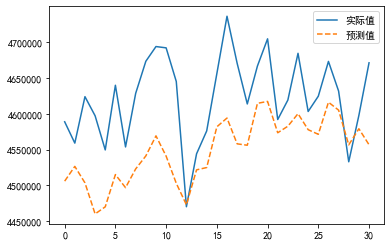

In [39]:
#2019-06-01到2019-07-01测试集实际值与预测值对比
plt.plot(sup_water_test['y'].values, label='实际值')
plt.plot(forecast['yhat'].values,linestyle='--', label='预测值')
plt.legend(loc='best')
plt.show()

In [40]:
#计算测试数据集预测值的mape
np.mean(np.abs((forecast['yhat'].values - sup_water_test['y'].values)/sup_water_test['y'].values))

0.016323043434675246

**mape=1.63%,测试结果符合模型精度要求**

## 8. 模型应用

In [41]:
m = Prophet(holidays=holidays,
    growth='logistic', 
    interval_width = 0.8,           #预测不确定区间宽度
    n_changepoints = 25,            #识别变点的上限数量             
    changepoint_range = 0.8 ,       #使用前80%比例数据作为变点识别数据
    changepoint_prior_scale = 0.05, #changepoint_prior_scale越大，识别为变点越多；越小，识别为变点越少。
    holidays_prior_scale=10)        #holidays_prior_scale越大，假期对目标值的影响越大。越小，假期对目标值的影响越小。
m.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=10) #fourier_order越大，对周期变化的拟合越细致也越容易过拟合。
m.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=10)#prior_scale越大，对于目标变量影响越大。
m.add_regressor('平均温度',prior_scale=10,mode='multiplicative') #回归量采用乘法模型

In [42]:
#按照测试集前两年的数据训练模型
sup_water['cap']= 5100000 #设置增长饱和值
m.fit(sup_water[-730:])

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [44]:
#预测未来30天
future = m.make_future_dataframe(periods=29,freq = 'd', 
                                 include_history = False)

#输入预测期的饱和最大值
future['cap'] = 5100000
#输入天气预报中未来30日的平均温度
future['平均温度'] = [32,32.5,31.5,31.5,31.5,31.5,31.5,28.5,29,29.5,30,30,30.5,30.5,30.5,29.5,30.5,29,28.5,26,27,26.5,28,30.5,29.5,31,32,32.5,32]
future 

,ds,cap,平均温度
0,2019-07-13,5100000,32.0
1,2019-07-14,5100000,32.5
2,2019-07-15,5100000,31.5
3,2019-07-16,5100000,31.5
4,2019-07-17,5100000,31.5
5,2019-07-18,5100000,31.5
6,2019-07-19,5100000,31.5
7,2019-07-20,5100000,28.5
8,2019-07-21,5100000,29.0
9,2019-07-22,5100000,29.5


In [45]:
#正式预测
forecast = m.predict(future)

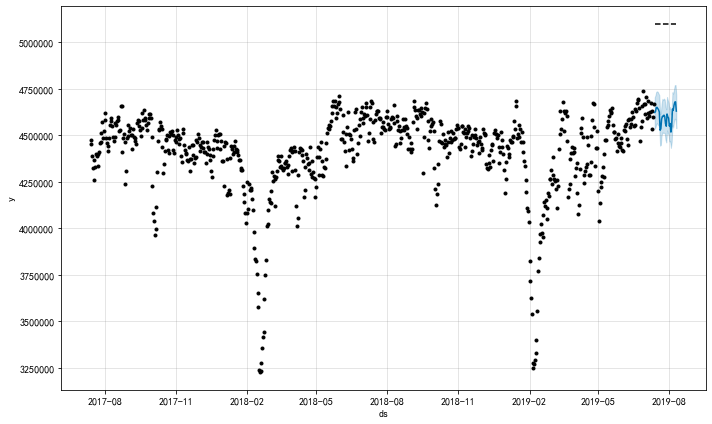

In [46]:
fig = m.plot(forecast)

In [49]:
#未来29天的预测结果
tmp = forecast[['ds','yhat']]
tmp['yhat']=tmp['yhat'].astype('int')
tmp

,ds,yhat
0,2019-07-13,4623013
1,2019-07-14,4627395
2,2019-07-15,4648671
3,2019-07-16,4650884
4,2019-07-17,4644529
5,2019-07-18,4637808
6,2019-07-19,4625555
7,2019-07-20,4527595
8,2019-07-21,4535232
9,2019-07-22,4587203
